In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn import linear_model as lin
import numpy as np

=~=~=~=~=~=~=~=~=~=~=~= PuTTY log 2025.03.10 00:30:16 =~=~=~=~=~=~=~=~=~=~=~=

ESP-ROM:esp32s3-20210327

Build:Mar 27 2021

rst:0x1 (POWERON),boot:0x8 (SPI_FAST_FLASH_BOOT)

SPIWP:0xee

mode:DIO, clock div:1

load:0x3fce3808,len:0x4bc

load:0x403c9700,len:0xbd8

load:0x403cc700,len:0x2a0c

entry 0x403c98d0

Initializing SensorIMU...

Initialization of the sensor returned: All is well.

Device connected!

DMP enabled!

Initializing SensorFSR...

SensorFSR Intialized

SerialTX is ready to go

tx wasn't initialized... this is gonna be bad

IMUProcessor initialized with capacity: 7

All ready to go, will begin sending data

{"timestamp":55766, "integ":[22.42176, 0.00011], "mean":[0.00


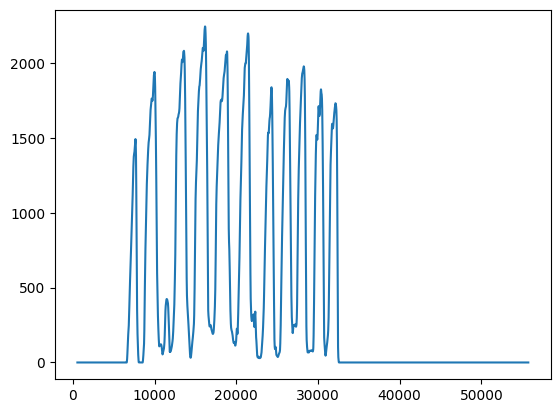

In [84]:
file = "fsrlog6.log"
with open(file, 'r') as f:
    data = f.readlines()

pd_data = {
    'timestamp': [],
    'mean': [],
    'integ': [],
    'elapsed': []
}

for row in data:
    try:
        row_dict = ast.literal_eval(row)
    except:
        print(row)
        continue
    for key in row_dict.keys():
        if key == 'ts':
            break
        if key == 'timestamp':
            pd_data[key].append(row_dict[key])
        else:
            pd_data[key].append(row_dict[key][0])
    

plt.plot(pd_data['timestamp'], pd_data['mean'])

=~=~=~=~=~=~=~=~=~=~=~= PuTTY log 2025.03.10 00:30:05 =~=~=~=~=~=~=~=~=~=~=~=

Starting...

Startup is complete

Calibration value: 462.44

HX711 measured conversion time ms: 11.43

HX711 measured sampling rate HZ: 87.47

HX711 measured settlingtime ms: 184

Note that the settling time may increase significantly if you use delay() in your sketch!



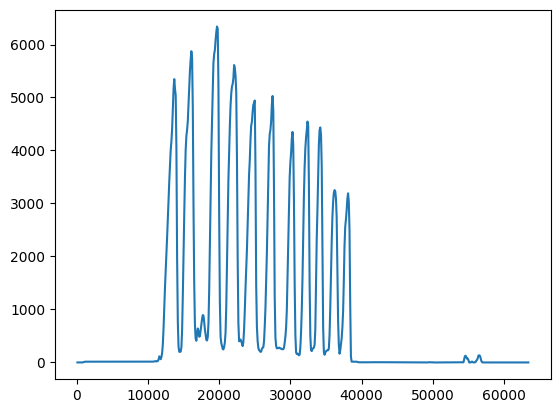

In [85]:
file2 = "lclog6.log"
with open(file2, 'r') as f:
    data2 = f.readlines()

times = []
lc_data = []

iter = 0
for row in data2:
    try:
        val = float(row.split(',')[0])
    except:
        print(row)
        continue
    
    iter += 100
    times.append(iter)
    lc_data.append(val)

plt.plot(times, lc_data)

In [90]:
for i, x in enumerate(pd_data['mean']):
    if x > 50:
        fsr_first = i
        break

for i, x in enumerate(lc_data):
    if x > 500:
        lc_first = i+3
        break
fsr_first, lc_first

(360, 124)

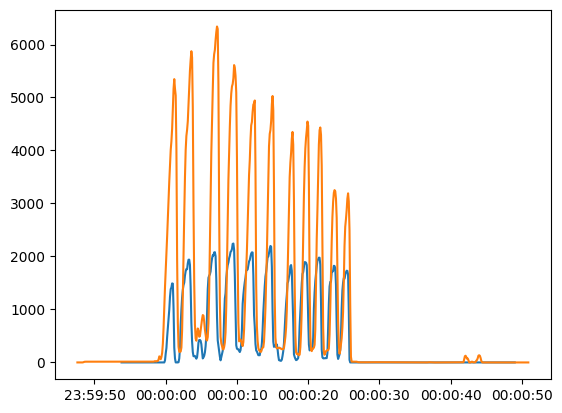

In [91]:
index = [pd.Timestamp(x - pd_data['timestamp'][fsr_first], unit='ms') for x in pd_data['timestamp']]
fsr_df = pd.DataFrame(pd_data, index=index)
fsr_df.pop('timestamp')
fsr_df.head()

index = [pd.Timestamp(x - times[lc_first], unit='ms') for x in times]
lc_df = pd.DataFrame(lc_data, index=index, columns=['lc'])

fsr_rs_df = fsr_df.resample('100ms').max()

plt.plot(fsr_rs_df.index, fsr_rs_df['mean'])
plt.plot(lc_df.index, lc_df['lc'])

In [92]:
comb_df = pd.concat((fsr_rs_df, lc_df), axis=1)
comb_df.head()
comb_df.columns = ['FSR', 'FSR_I', 'FSR_LA', 'LC']

In [93]:


def calibrate_fsr(dat, mode='calibrate'):
    dat['FSR2'] = dat['FSR'] ** 2
    dat['FSR_I2'] = dat['FSR_I'] ** 2
    dat['FSR_LA2'] = dat['FSR_LA'] ** 2
    
    X = dat[['FSR', 'FSR2', 'FSR_I', 'FSR_I2','FSR_LA', 'FSR_LA2']]
    # X = (X - X.mean()) / X.std()
    # X = dat[['FSR', 'FSR2']]
    # X = dat[['FSR', 'FSR_I', 'FSR2', 'FSR_I2']]
    # X = dat[['FSR', 'FSR2', 'FSR_LA', 'FSR_LA2']]
    y = dat['LC']
    weight = [1 if x < 5 else 1 for x in dat['FSR']]

    lr = lin.LinearRegression(fit_intercept=False)
    lr.fit(X, y, sample_weight=weight)
    score = lr.score(X, y, sample_weight=weight)
    pred = np.multiply(lr.predict(X), weight)
    print(lr.coef_)
    print(lr.intercept_)
    print(score)
    return pred

In [94]:
reg_data = comb_df.iloc[lc_first-10:-50]
pred = calibrate_fsr(reg_data)

[ 9.63297037e-01  3.04822463e-04  2.41947032e+01 -1.20888952e+00
  4.82247056e-01 -5.74696649e-05]
0.0
0.5640668617973814


C:\Users\682x\AppData\Local\Temp\ipykernel_10336\3846581305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['FSR2'] = dat['FSR'] ** 2
C:\Users\682x\AppData\Local\Temp\ipykernel_10336\3846581305.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['FSR_I2'] = dat['FSR_I'] ** 2
C:\Users\682x\AppData\Local\Temp\ipykernel_10336\3846581305.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

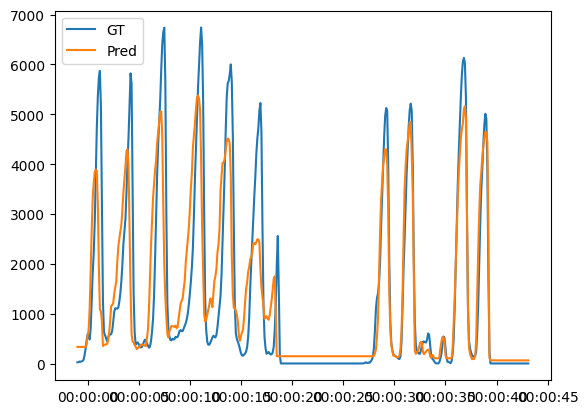

In [81]:
plt.plot(reg_data.index, reg_data['LC'])
plt.plot(reg_data.index, pred)
plt.legend(['GT', 'Pred'])